# Lab: Support Vector Machines  
  
  From *Introduction to Statistical Learning with Applications in R*  
  
  We will use the `e1071` library in `R` to demonstrate the support vector classifier and support vector machines. Another option is the `LiblineaR` library, which is useful for very large linear problems.

## Part One: Support Vector Classifier

The `e1071` library contains implementations for a number of statistical learning methods. In particular, the `svm()` function can be used to fit a support vector classifier when the argument `kernal='linear'` is used. A `cost` argument allows us to specify the cost of a violation to the margin. When `cost` is small, then the margins will be wide and many support vectors will be on the margin or will violate the margin. When `cost` is large, then the margins will be narrow and there will be few support vectors on the margin or violating the margin.  
  
  We now use the `svm()` function to fit the support vector classifier for a given value of the `cost` parameter. Here we demonstrate the use of this function on a two-dimensional example so that we can plot the resulting decision boundary. We begin by generating the observations, which belong to two classes, and checking whether the classes are linearly separable.

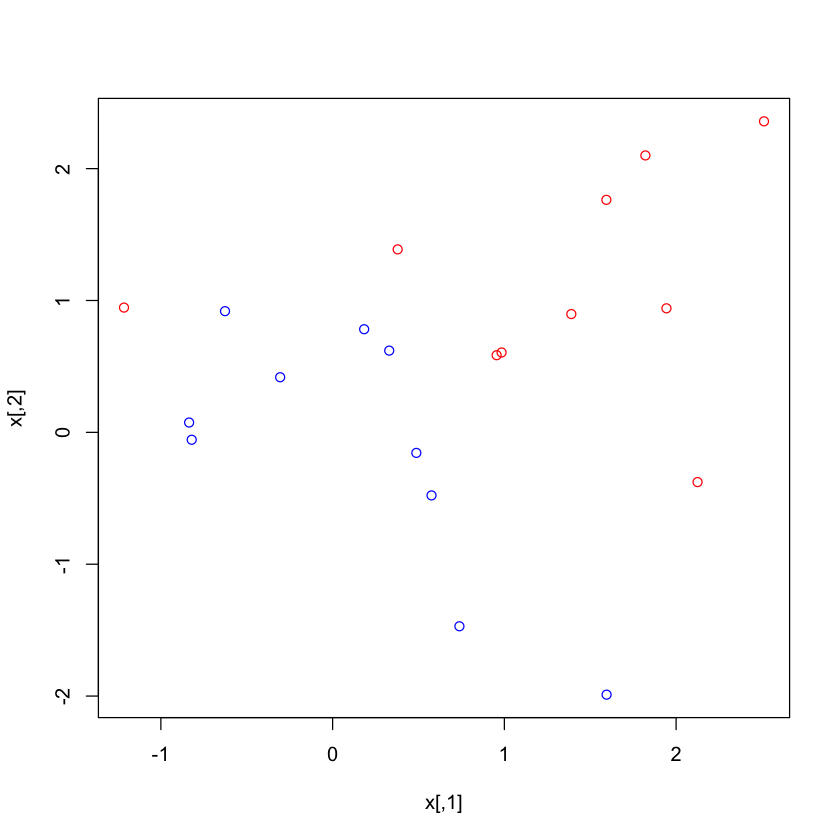

In [12]:
set.seed(1)
x <- matrix(rnorm(40), ncol=2)
y <- c(rep(-1, 10), rep(1, 10))
# Add one to class y==1
x[y==1,] <- x[y==1,] + 1
# Plot x with color set to 2 for values with y==1 and 4 for values with y==-1
plot(x, col=(3-y)) 

We can see above that the classes are not linearly separable. Next, we will fit a support vector classifier. Note that in order for the `svm()` function to perform classification (as opposed to SVM-based regression), we must encode the response as a factor variable. We now create a data frame with the response coded as a factor.

In [14]:
#install.packages('e1071')
library(e1071)
df <- data.frame(x=x, y=as.factor(y))
svc.fit <- svm(y ~ ., data=df, kernel='linear', cost=10, scale=FALSE)

The argument `scale=FALSE` tells the `svm()` function not to scale each feature to have mean zero and standard deviation one. Depending on the application, one might prefer to use `scale=TRUE`.  
  
  We can now plot the support vector classifier obtained:

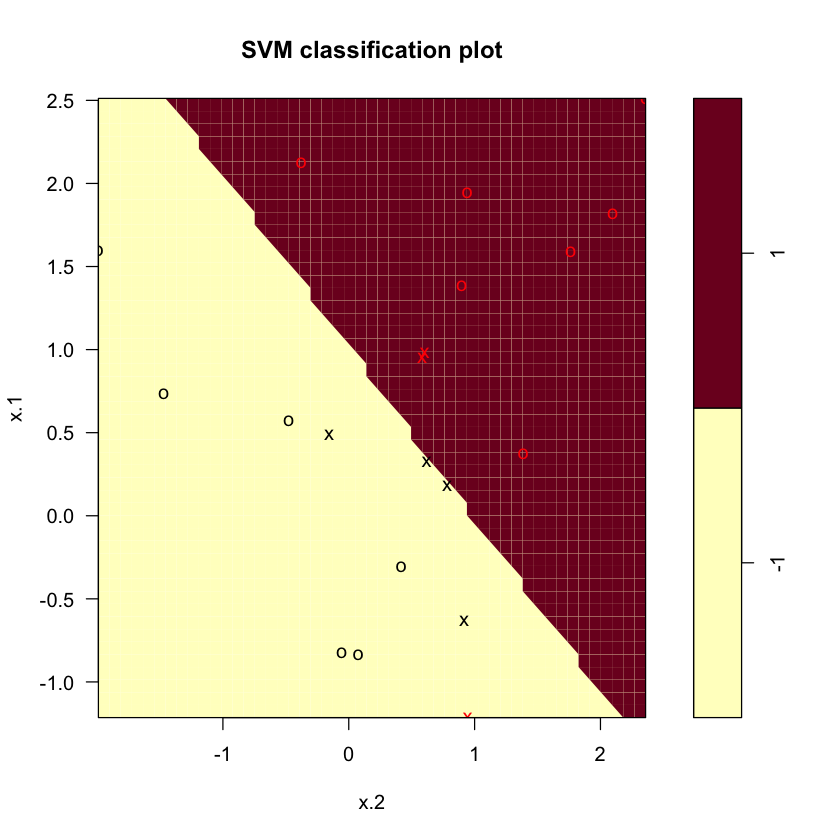

In [15]:
plot(svc.fit, df)

Note that the two arguments to the `plot.svm()` function are the output of the call to `svmn()`, as well as the data used in the call to `svm()`. The region of feature space that will be assigned to the -1 class is shown in yellow, and the region that will be assigned to the +1 class is shown in red. The decision boundary between the two classes is linear (because we used the argument `kernel='linear'`), though due to the way in which the plotting function is implemented in this library, the decision boundary looks somewhat jagged in the plot. (Note that here the second feature is plotted on the x-axis and the first feature is plotted on the y-axis, in contrast to the behavior of the usual `plot()` function in `R`). The support vectors are plotted as crosses, and the remaining observations are plotted as circles; we see here that there are seven support vectors. We can determine their identities as follows:

In [16]:
svc.fit$index

[1]  1  2  5  7 14 16 17

We can obtain some basic information about the support vector classifier using the `summary()` function:

In [17]:
summary(svc.fit)


Call:
svm(formula = y ~ ., data = df, kernel = "linear", cost = 10, scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  10 

Number of Support Vectors:  7

 ( 4 3 )


Number of Classes:  2 

Levels: 
 -1 1




This tells us, for instance, that a linear kernal was used with `cost=10`, and that there were seven support vectors, four in one class and three in the other.  
  
  What if we instead used a smaller value of the cost parameter?

In [18]:
svc.fit <- svm(y ~ ., data=df, kernel='linear', cost=0.1, scale=FALSE)

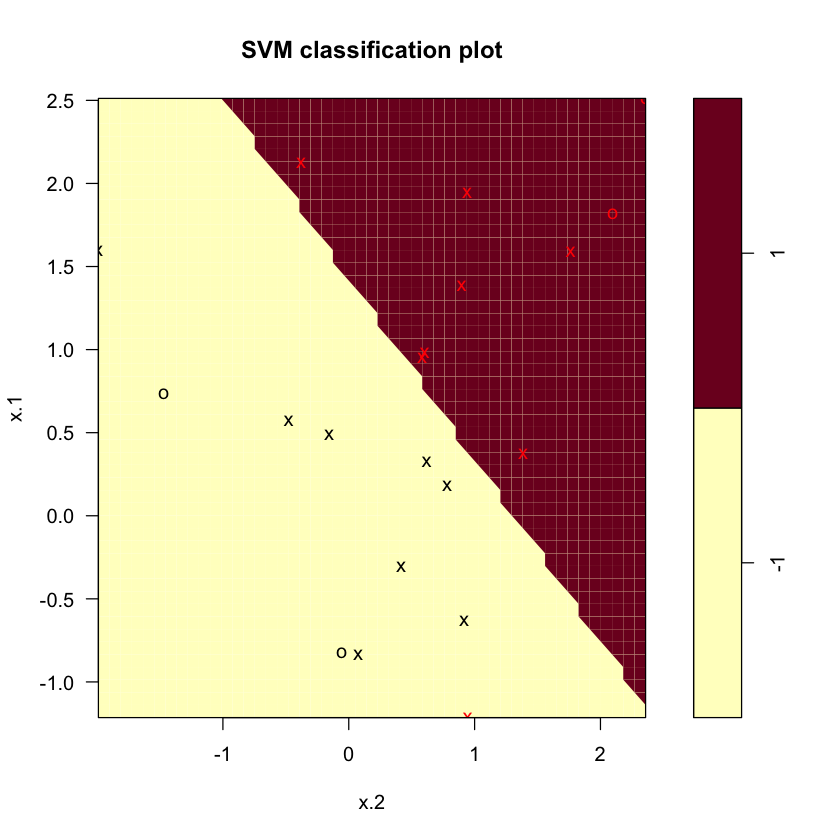

In [19]:
plot(svc.fit, df)

In [20]:
svc.fit$index

[1]  1  2  3  4  5  7  9 10 12 13 14 15 16 17 18 20

Now that a smaller value of the cost parameter is being used, we obtain a larger number of support vectors, because the margin is now wider. Unfortunately, the `svm()` function does not explicitly output the coefficients of the linear decision boundary obtained when the support vector classifier is fit, nor does it output the width of the margin.  
  
  The `e1071` library includes a built-in function, `tune()`, to perform cross-validation. By default, `tune()` performs ten-fold cross-validation on a set of models of interest. In order to use this function, we pass in relevant information about the set of models that are under consideration. The following command indicates that we want to compare SVMs with a linear kernel, using a range of values of the `cost` parameter. 

In [24]:
set.seed(1)
tune.out <- tune(svm, y ~ ., data=df, kernel='linear', ranges=list(cost=c(0.001,0.01,0.1,1,5,10,100)))

We can easily access the cross-validation errors for each of these models using the `summary()` command:

In [25]:
summary(tune.out)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost
  0.1

- best performance: 0.05 

- Detailed performance results:
   cost error dispersion
1 1e-03  0.55  0.4377975
2 1e-02  0.55  0.4377975
3 1e-01  0.05  0.1581139
4 1e+00  0.15  0.2415229
5 5e+00  0.15  0.2415229
6 1e+01  0.15  0.2415229
7 1e+02  0.15  0.2415229


We see that `cost=0.1` results in the lowest cross-validation error rate. The `tune()` function stores the best model obtained, which can be accessed as follows:

In [26]:
best.mod <- tune.out$best.model
summary(best.mod)


Call:
best.tune(method = svm, train.x = y ~ ., data = df, ranges = list(cost = c(0.001, 
    0.01, 0.1, 1, 5, 10, 100)), kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  0.1 

Number of Support Vectors:  16

 ( 8 8 )


Number of Classes:  2 

Levels: 
 -1 1




The `predict()` function can be used to predict the class label on a set of test observations, at any given value oof the cost parameter. We begin by generating a test data set.

In [27]:
x.test <- matrix(rnorm(40), ncol=2)
y.test <- sample(c(-1,1), nrow(x.test), rep=TRUE)
x.test[y.test==1,] <- x.test[y.test==1,] + 1
test <- data.frame(x=x.test, y=as.factor(y.test))

Now we predict the class labels of these test observations. Here we use the best model obtained through cross-validation in order to make predictions.

In [28]:
y.pred <- predict(best.mod, newdata=test)
table(predicted=y.pred, observed=test$y)

         observed
predicted -1 1
       -1  9 1
       1   2 8

Thus, with this value of `cost` (0.1), 17 of the 20 test observations are correctly calssified. What if we had instead used `cost=0.01`?

In [29]:
svc.fit <- svm( y ~ ., data=df, kernel='linear', cost=0.01, scale=FALSE)
y.pred <- predict(svc.fit, newdata=test)
table(predicted=y.pred, observed=test$y)

         observed
predicted -1  1
       -1 11  6
       1   0  3

In this case we are now only correctly classifying 14 of the 20 observations.  
  
  Now consider a situation in which the two classes *are* linearly separable. Then we can find a separating hyperplane using the `svm()` function. We first further separate the two classes in our simulated data so that they are linearly separable:

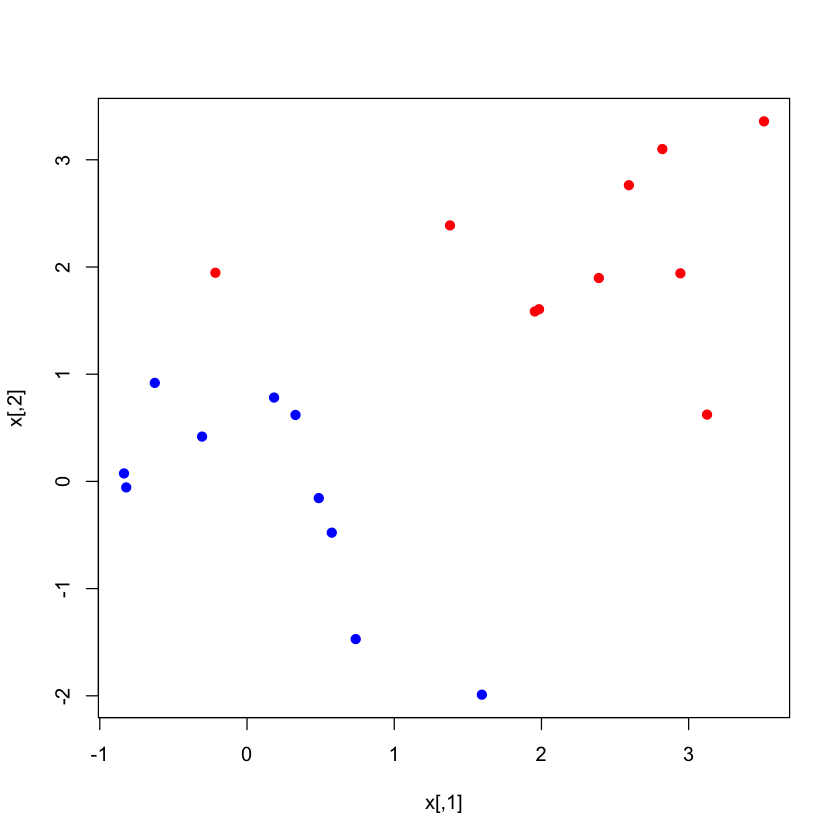

In [31]:
x[y==1,] <- x[y==1,] + 1
plot(x, col=(3-y), pch=19)

Now the observations are just barely linearly separable. We fit the support vector classifer and plot the resulting hyperplane, using a very large value of `cost` so that no observations are misclassified.

In [32]:
df <- data.frame(x=x, y=as.factor(y))
svc.fit <- svm(y ~ ., data=df, kernel='linear', cost=1e+5)
summary(svc.fit)


Call:
svm(formula = y ~ ., data = df, kernel = "linear", cost = 1e+05)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1e+05 

Number of Support Vectors:  3

 ( 1 2 )


Number of Classes:  2 

Levels: 
 -1 1




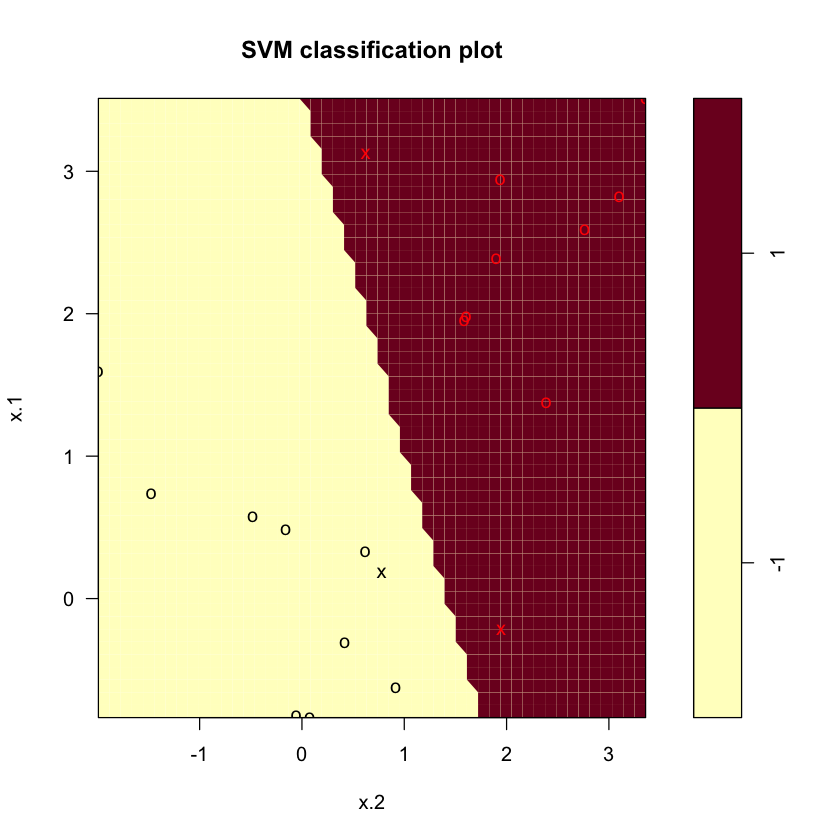

In [33]:
plot(svc.fit, df)

No training errors were made and only three support vectors were used. However, we can see from the figure that the margin is very narrow (because the observations that are not support vectors, indicated as circles, are very close to the decision boundary). It seems likely that this model will perform poorly on test data. We now try a smaller value of `cost`:

In [34]:
svc.fit <- svm(y ~ ., data=df, kernel='linear', cost=1)
summary(svc.fit)


Call:
svm(formula = y ~ ., data = df, kernel = "linear", cost = 1)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 

Number of Support Vectors:  5

 ( 2 3 )


Number of Classes:  2 

Levels: 
 -1 1




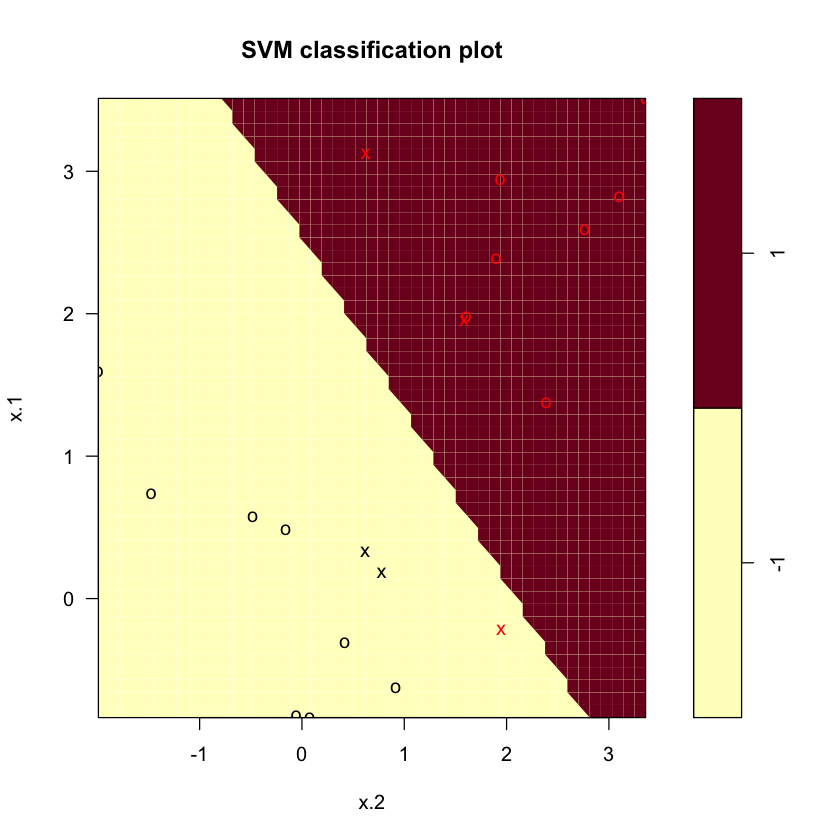

In [35]:
plot(svc.fit, df)

Using `cost=1`, we misclassify a training observation, but we also obtain a much wider margin and make use of seven support vectors. It seems likely that this model will perform better on test data than the model with `cost=1e+5`.

#  
  
  

## Part Two: Support Vector Machine  
  
  In order to fit an SVM using a non-linear kernel, we once again use the `svm()` function. However, now we use a different value of the parameter `kernel`. To fitan SVM with a polynomial kernel we use `kernel='polynomial'`, and to fit an SVM with a radial kernel we use `kernel='radial'`. In the former case we also use the `degree` argument to specify a degree for the polynomial kernel (this is $d$ in the kernel function). IN the latter case, we use `gamma` to specify a value of $\gamma$ for the radial basis kernel.  
  
  We first generate some data with a non-linear calss boundary, as follows:

In [82]:
set.seed(1)
x <- matrix(rnorm(400), ncol=2)
x[1:100,] <- x[1:100,] + 2
x[101:150,] <- x[101:150,] - 2
y <- c(rep(1,150), rep(-1,50))
df <- data.frame(x=x, y=as.factor(y))

Plotting the data makes it clear that the class boundary is indeed non-linear:

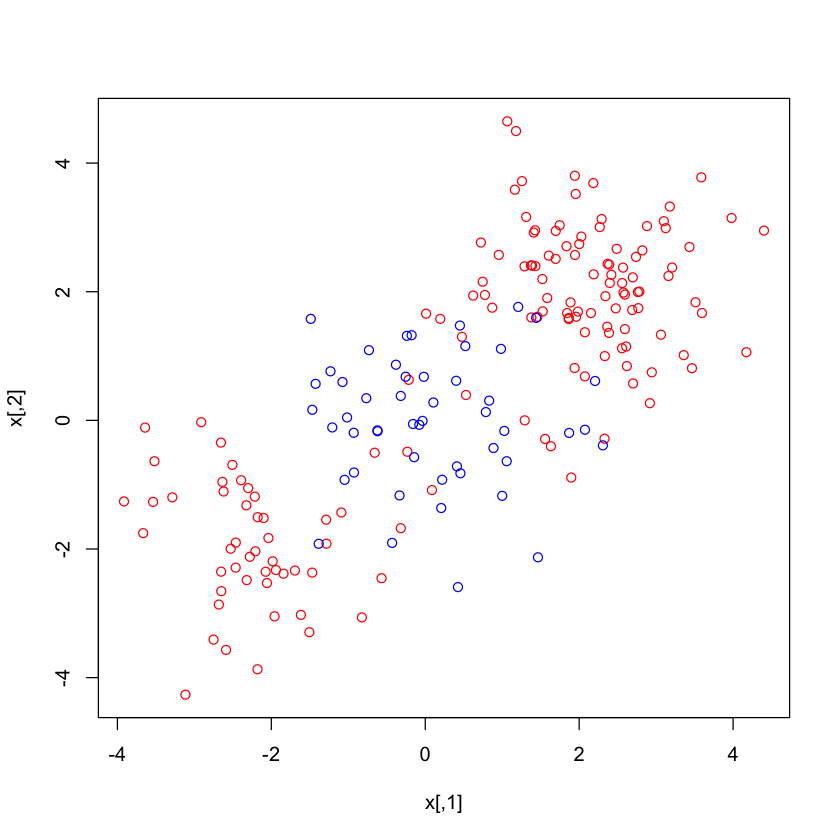

In [99]:
plot(x, col=(3-y))

Now we randomly split the data into training and test groups and then fit the training data using the `svm()` function with a radial kernel and $\gamma = 1$:

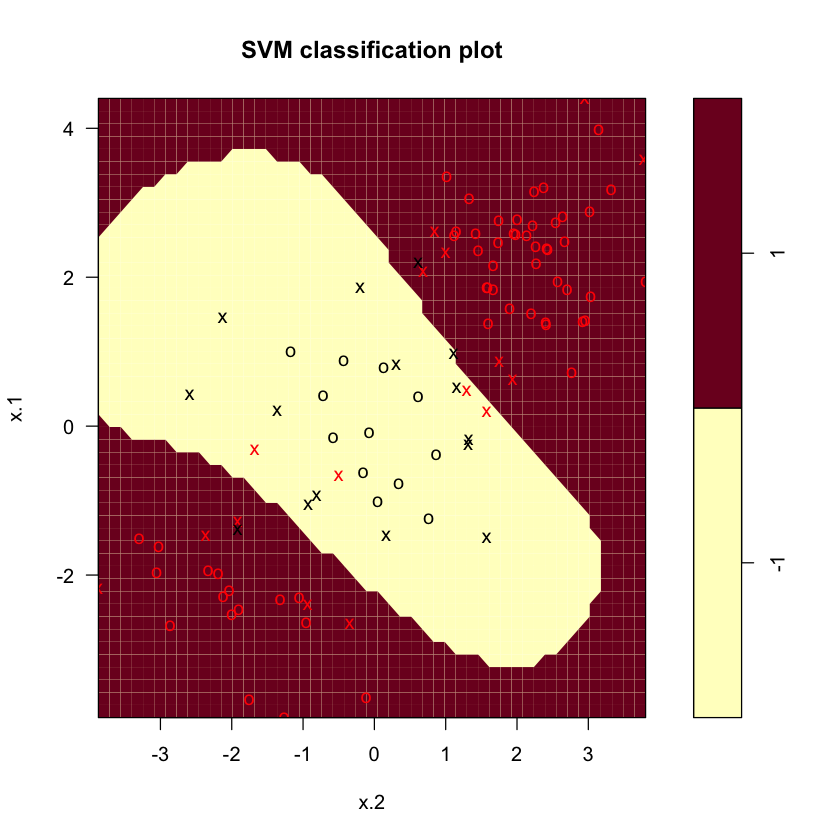

In [84]:
train <- sample(1:nrow(df), nrow(df)/2)
svm.fit <- svm(y ~ ., data= df[train,], kernel='radial', gamma=1, cost=1)
plot(svm.fit, df[train,])

The plot shows that the resulting SVM has a decidedly non-linear boundary. The `summary()` function can be used to obtain some information about the SVM fit:

In [85]:
summary(svm.fit)


Call:
svm(formula = y ~ ., data = df[train, ], kernel = "radial", gamma = 1, 
    cost = 1)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  31

 ( 16 15 )


Number of Classes:  2 

Levels: 
 -1 1




WE can see from the figure that there are a fair number of training errors in this SVM fit. If we increase the value of `cost`, we can decrease the number of training errors. However, this comes at the price of a more irregular decision boundary that seems to be at risk of overfitting the data.

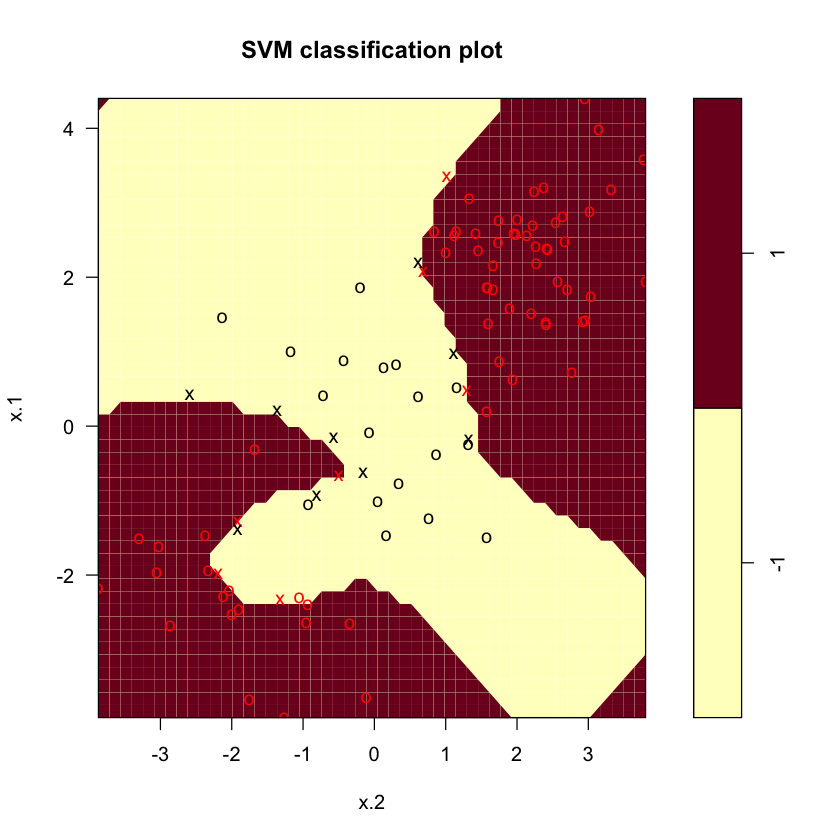

In [86]:
svm.fit <- svm(y ~ ., data=df[train,], kernel='radial', gamma=1, cost=1e+5)
plot(svm.fit, df[train,])

We can perform cross-validation using `tune()` to select the best choice of $\gamma$ and `cost` for an SVM with a radial kernel:

In [87]:
set.seed(1)
tune.out <- tune(svm, y ~ ., data=df[train,], kernel='radial',
                ranges=list(cost=c(0.1,1,10,100,1000), gamma=c(0.5,1,2,3,4))) # gamma and cost in list()
summary(tune.out)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
    1   0.5

- best performance: 0.07 

- Detailed performance results:
    cost gamma error dispersion
1  1e-01   0.5  0.26 0.15776213
2  1e+00   0.5  0.07 0.08232726
3  1e+01   0.5  0.07 0.08232726
4  1e+02   0.5  0.14 0.15055453
5  1e+03   0.5  0.11 0.07378648
6  1e-01   1.0  0.22 0.16193277
7  1e+00   1.0  0.07 0.08232726
8  1e+01   1.0  0.09 0.07378648
9  1e+02   1.0  0.12 0.12292726
10 1e+03   1.0  0.11 0.11005049
11 1e-01   2.0  0.27 0.15670212
12 1e+00   2.0  0.07 0.08232726
13 1e+01   2.0  0.11 0.07378648
14 1e+02   2.0  0.12 0.13165612
15 1e+03   2.0  0.16 0.13498971
16 1e-01   3.0  0.27 0.15670212
17 1e+00   3.0  0.07 0.08232726
18 1e+01   3.0  0.08 0.07888106
19 1e+02   3.0  0.13 0.14181365
20 1e+03   3.0  0.15 0.13540064
21 1e-01   4.0  0.27 0.15670212
22 1e+00   4.0  0.07 0.08232726
23 1e+01   4.0  0.09 0.07378648
24 1e+02   4.0  0.13 0.14181365
25 1e+03   4.0  0.15 0

Therefore, the best choice of parameters involves `cost=1` and `gamma=0.5`. We can view the test set predictions for this model by applying the `predict()` function to the data.

In [88]:
# Extract the best performing model from the output of tune()
best.mod <- tune.out$best.model

# Make predictions on test data
y.pred <- predict(best.mod, newdata=df[-train,])

# Create confusion matrix
table(predicted=y.pred, observed=df[-train,]$y)

         observed
predicted -1  1
       -1 21 10
       1   2 67

In [89]:
(67 + 21) / 100

[1] 0.88

In [90]:
mean(y.pred == df[-train,'y'])

[1] 0.88

We can see above that the SVM correctly classifies 88% of our test observations.

#  
  
  

## Part Three: ROC Curves  
  
  The `ROCR` package can be used to produce ROC curves. First we have to write a short function to plot an ROC curve given a vector containing a numerical score for each observation, `pred`, and a vector containing the class label for each observation, `truth`.

In [91]:
#install.packages('ROCR')
library(ROCR)

plot_roc <- function(pred, truth, ...) {
    pred.ob <- prediction(pred, truth)
    perf <- performance(pred.ob, 'tpr', 'fpr')
    plot(perf, ...)
}

SVMs and support vector classifiers output class labels for each observation. However, it is also possible to obtain *fitted values* for each observation, which are the numerical scores used to obtain the class labels. For instance, in the case of a support vector classifier, the fitted value for an observation $X = (X_1, X_2, ... , X_p)^T$ takes the form $\hat{\beta}_0 + \hat{\beta}_1X_1 + \hat{\beta}_2X_2 + ... + \hat{\beta}_pX_p$.  
  
  In essence, the sign of the fitted value determines on which side of the decision boundary the observation lies. Therefore, the relationship between the fitted value and the class prediction for a given observation is simple: If the fitted value exceeds zero, then the observation is assigned to one class, and if it is less than zero, then it is assigned to the other. In order to obtain the fitted values for a given SVM model fit, we use the `decision.values=TRUE` option when fitting `svm()`. Then the `predict()` function will output the fitted values.

In [92]:
svm.fit.opt <- svm(y ~ ., data=df[train,], kernel='radial', gamma=0.5, cost=1, decision.values=TRUE)
fitted <- attributes(predict(svm.fit.opt, newdata=df[train,], decision.values=TRUE))$decision.values

Now we can produce the ROC plot:

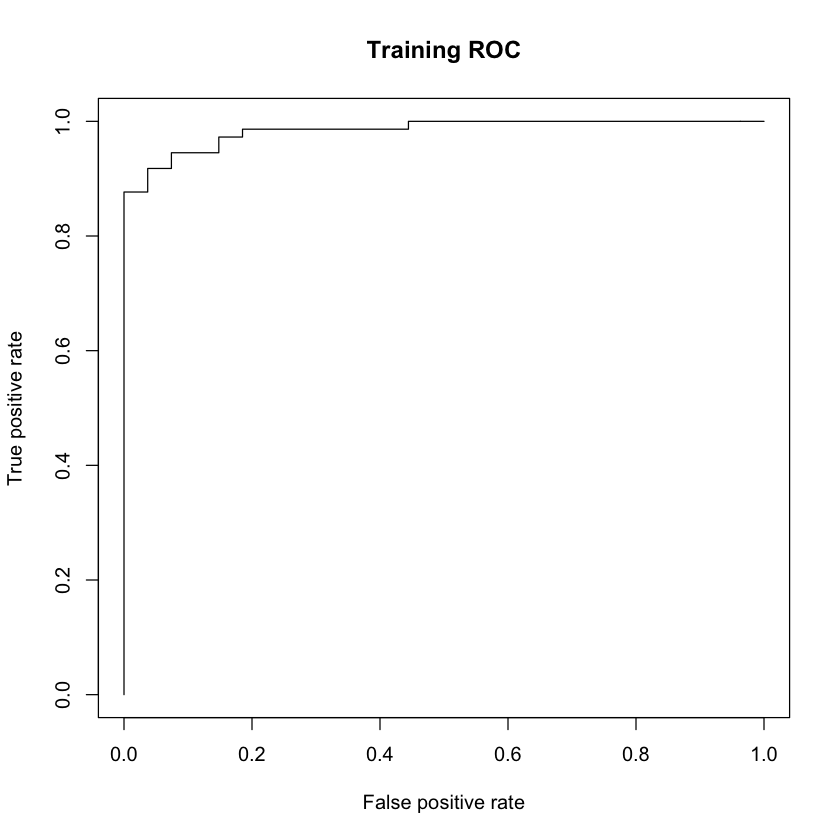

In [93]:
plot_roc(fitted, df[train,'y'], main='Training ROC')

SVM appears to be producing accurate predictions. By increasing $\gamma$ we can produce a more flexible fit and generate further improvements in accuracy.

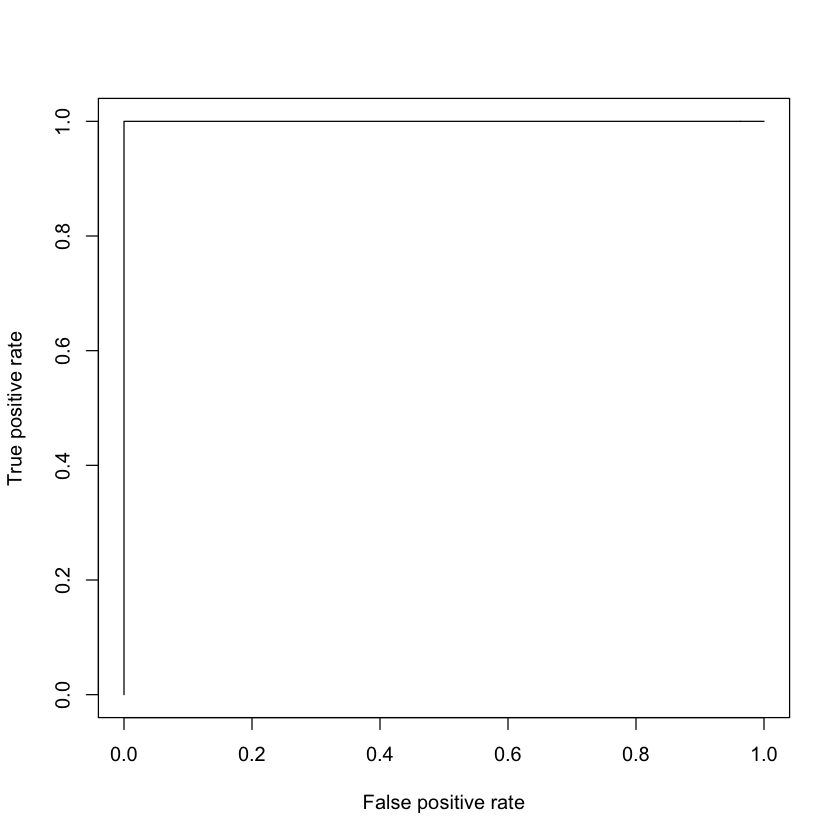

In [96]:
svm.fit.flex <- svm(y ~ ., data=df[train,], kernel='radial', gamma=50, cost=1, decision.values=TRUE)
fitted <- attributes(predict(svm.fit.flex, df[train,], decision.values=TRUE))$decision.values
plot_roc(fitted, df[train,]$y)

However, these ROC curves are all on the training data. We are really more interested in the level of prediction accuracy on the test data. When we compute the ROC curves on the test data, the model with $\gamma=0.5$ appears to provide the most accurate results.

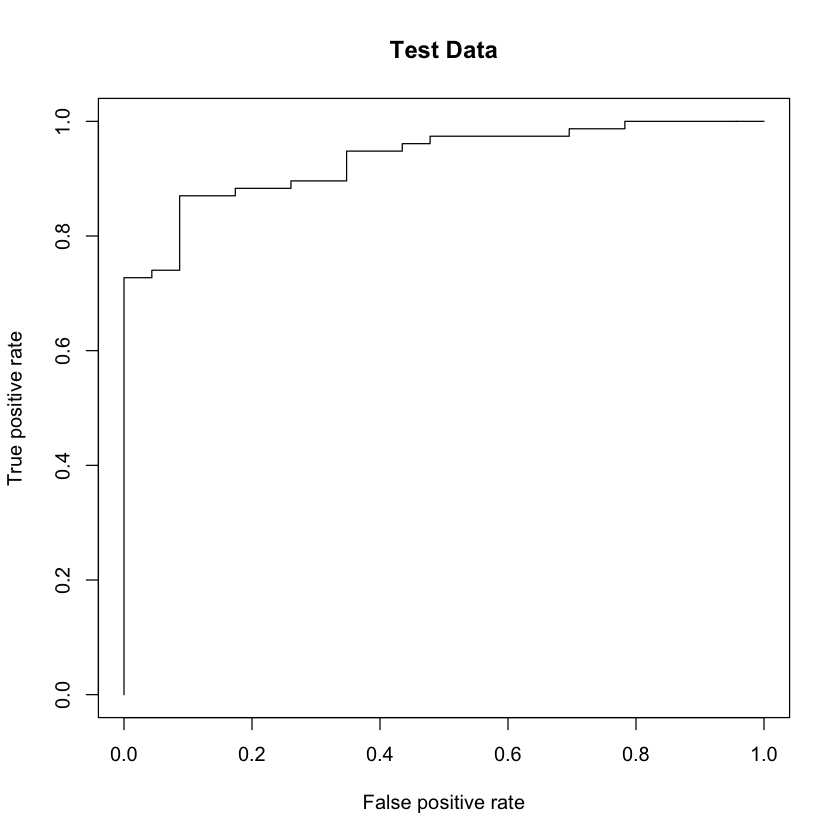

In [97]:
fitted <- attributes(predict(svm.fit.opt, df[-train,], decision.values=TRUE))$decision.values
plot_roc(fitted, df[-train,]$y, main='Gamma = 0.5')

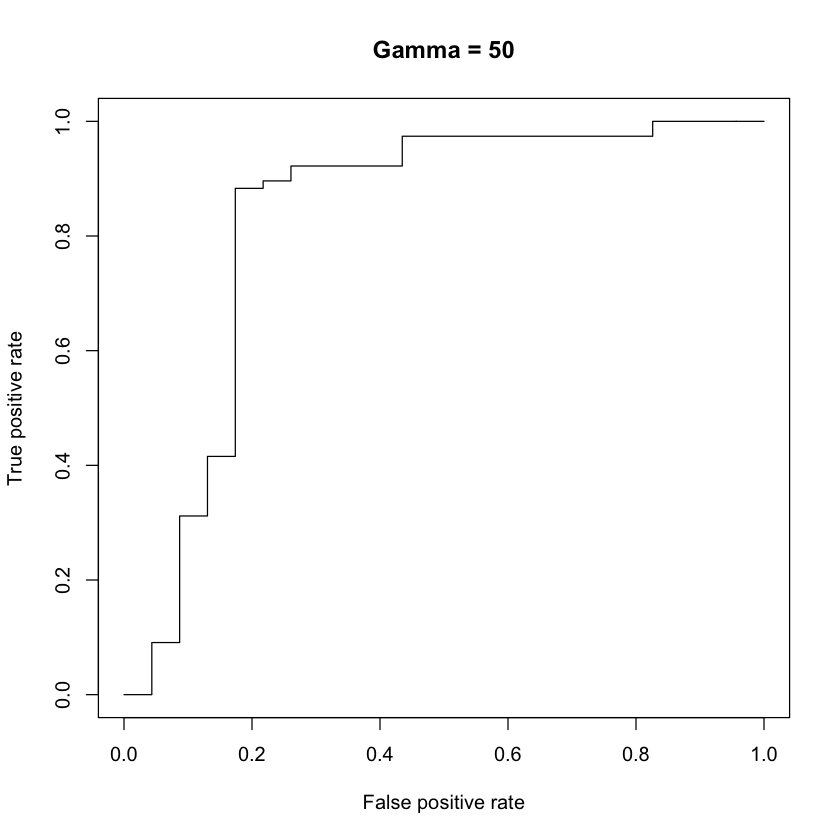

In [98]:
fitted <- attributes(predict(svm.fit.flex, df[-train,], decision.values=TRUE))$decision.values
plot_roc(fitted, df[-train,]$y, main='Gamma = 50')

#   
  
  

#  
  
  

## Part Four: SVM with Multiple Classes  
  
  If the response vector is a factor containing more than two levels, then the `svm()` function will perform multi-class classification using the one-versus-one approach. We explore that setting here by generating a third class of observations.

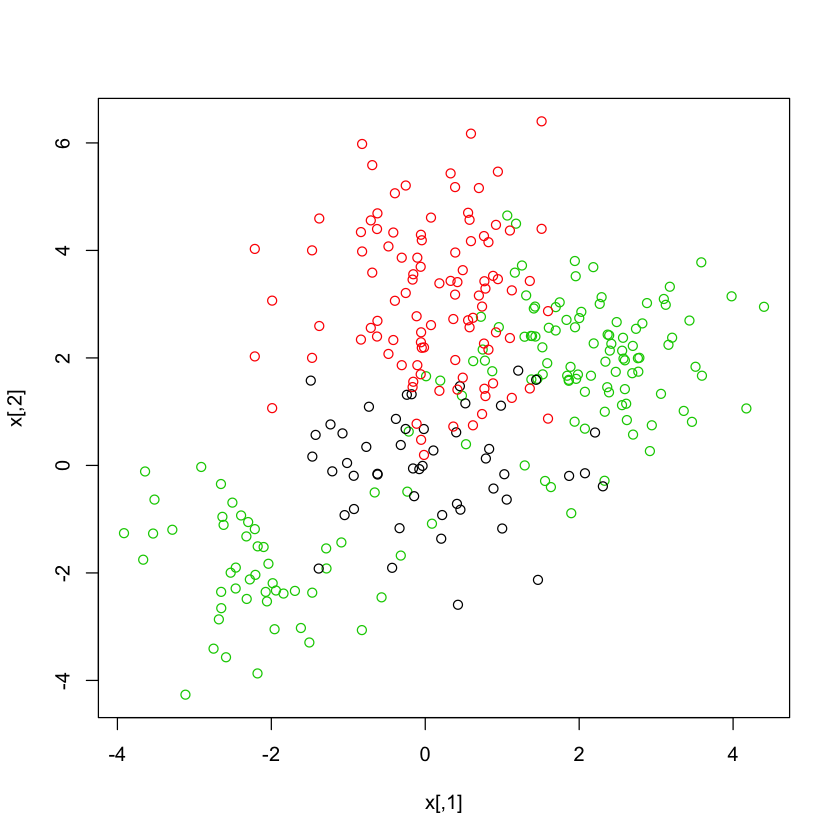

In [107]:
set.seed(1)
x <- rbind(x, matrix(rnorm(100), ncol=2))
y <- c(y, rep(0,50))
x[y==0,2] <- x[y==0,2] + 2
df <- data.frame(x=x, y=as.factor(y))
plot(x, col=(y+2))

We now fit an SVM to the data:

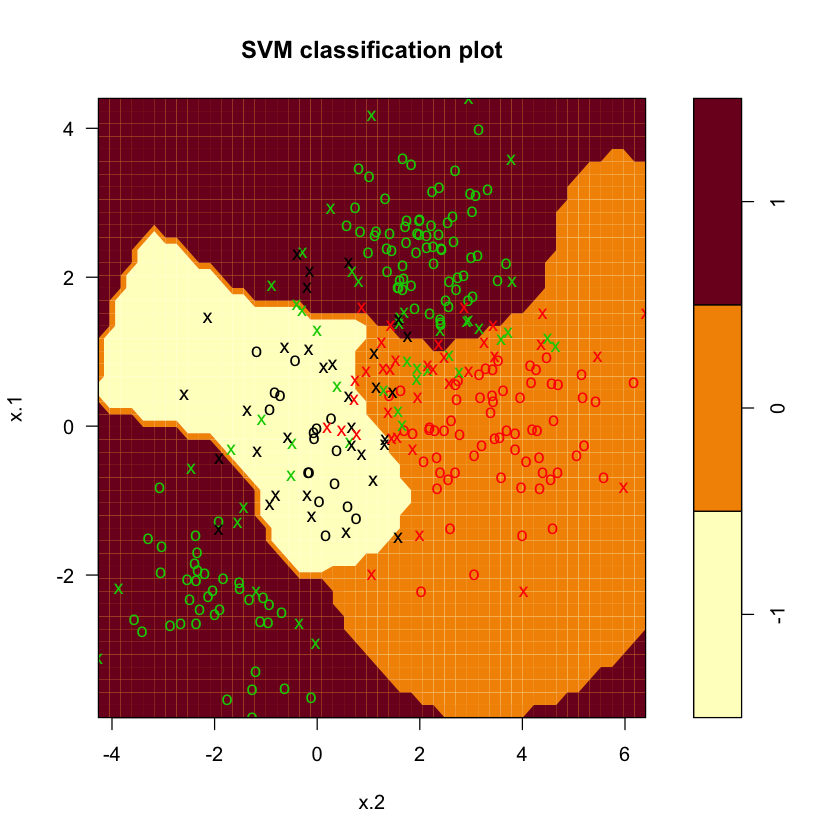

In [108]:
svm.fit <- svm(y ~ ., data=df, kernel='radial', cost=10, gamma=1)
plot(svm.fit, df)

The `e1071` library can also be used to perform support vector regression, if the response vector that is passed into `svm()` is numerical rather than a factor.

## Part Five: Application to Gene Expression Data  
  
  We now examine the `Khan` dataset, which cossists of a number of tissue samples corresponding to four distinct types of small round blue cell tumors. For each tissue sample, gene expression measurements are available. The dataset consists of training data, `xtrain`, `ytrain`, and testing data, `xtest` and `ytest`.

In [100]:
library(ISLR)
names(Khan)

[1] "xtrain" "xtest"  "ytrain" "ytest"

In [101]:
dim(Khan$xtrain)

[1]   63 2308

In [102]:
dim(Khan$xtest)

[1]   20 2308

In [103]:
length(Khan$ytrain)

[1] 63

In [104]:
length(Khan$ytest)

[1] 20

This dataset consists of expression measurements for 2,308 genes. The training and test sets consist of 63 and 20 observations, respectively.

In [109]:
table(Khan$ytrain)


 1  2  3  4 
 8 23 12 20 

In [110]:
table(Khan$ytest)


1 2 3 4 
3 6 6 5 

We'll use a support vector approach to predict cancer subtype using gene expression measurements. In this dataset, there are a very large number of features relative to the number of observations. This suggests that we should use a linear kernal, because the additional flexibility that will result from using a polynomial or radial kernel is unnecessary.

In [111]:
df <- data.frame(x=Khan$xtrain, y=as.factor(Khan$ytrain))
out <- svm(y ~ ., data=df, kernel='linear', cost=10)
summary(out)


Call:
svm(formula = y ~ ., data = df, kernel = "linear", cost = 10)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  10 

Number of Support Vectors:  58

 ( 20 20 11 7 )


Number of Classes:  4 

Levels: 
 1 2 3 4




In [114]:
table(predicted=out$fitted, observed=df$y)

         observed
predicted  1  2  3  4
        1  8  0  0  0
        2  0 23  0  0
        3  0  0 12  0
        4  0  0  0 20

We see above that there are *no* training errors. In fact, this is not surprising, because the large number of variables relative to the number of observations implies that it is easy to find hyperplanes that fully separate the classes. We are most interested in the support vector classifier's performance on the test observations.

In [115]:
test <- data.frame(x=Khan$xtest, y=as.factor(Khan$ytest))
test.pred <- predict(out, newdata=test)
table(predicted=test.pred, observed=test$y)

         observed
predicted 1 2 3 4
        1 3 0 0 0
        2 0 6 2 0
        3 0 0 4 0
        4 0 0 0 5

We see above that using a support vector classifier with `cost=10` yields two test set errors on this data.